In [28]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import datasets
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


#### Load Model

In [21]:
dinov2_vits14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')

Using cache found in C:\Users\alexa/.cache\torch\hub\facebookresearch_dinov2_main


#### Download Dataset

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alexa\.cache\huggingface\hub\models--facebook--dinov2-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


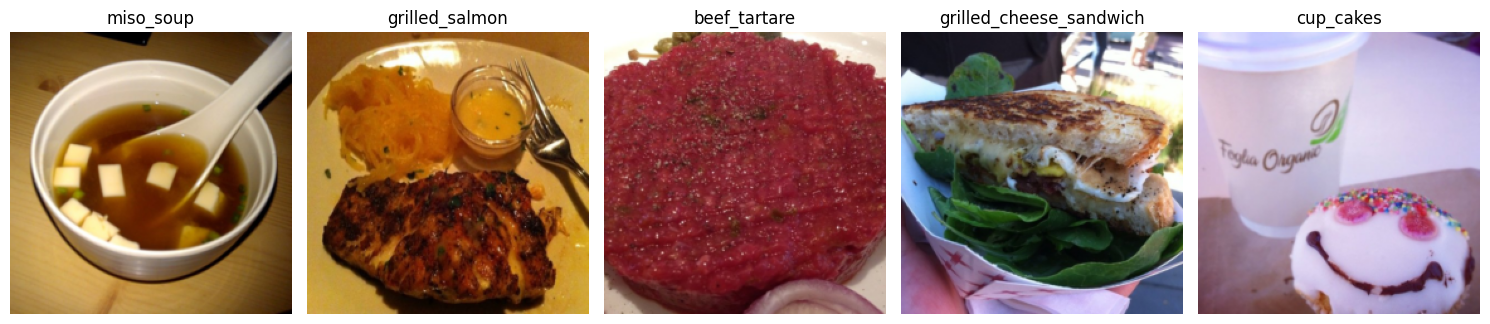

In [22]:
batch_size = 100
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors and normalize to [0, 1]
])

train_data = torchvision.datasets.Food101(root='food101', split='train', download=False, transform=transform)
test_data = torchvision.datasets.Food101(root='food101', split='test', download=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
# Randomly select 5 samples
random_indices = random.sample(range(len(train_data)), 5)
samples = [train_data[idx] for idx in random_indices]

# Plot the samples
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, (image, label) in enumerate(samples):
    axs[i].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
    axs[i].axis('off')  # Turn off axes
    axs[i].set_title(train_data.classes[label])  # Set the title to the class name

plt.tight_layout()
plt.show()

#### Replace Existing Head With New Head

In [23]:
# Inspect the current classification head
existing_head = dinov2_vits14_lc.linear_head

# Get the shape of the existing head
input_features = existing_head.in_features
output_features = existing_head.out_features

# Initialize a new classification head with random weights
new_head = nn.Linear(input_features, output_features)

print(f"New head initialized with shape: {input_features} -> {output_features}")
import copy

# Deep copy the model
dinov2_vits14_lc_original = copy.deepcopy(dinov2_vits14_lc)
dinov2_vits14_lc.linear_head = new_head

# freeze all weights in the dinov2_vits14_lc_copy except the new head
for param in dinov2_vits14_lc.parameters():
    param.requires_grad = False

# unfreeze the new head
for param in dinov2_vits14_lc.linear_head.parameters():
    param.requires_grad = True

New head initialized with shape: 1920 -> 1000


In [26]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vits14_lc.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dinov2_vits14_lc.linear_head.parameters(), lr=1e-3)
epochs = 10
epoch = 0
for i in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
    for batch_idx, (images, labels) in progress_bar:
        optimizer.zero_grad()
        # input = processor(images=batch[0], return_tensors="pt")
        input = processor(images=images, return_tensors="pt", padding=True).to(device)
        # input = processor(images=batch[0], return_tensors="pt").to(device)
        labels = labels.to(device)
        output = dinov2_vits14_lc(input["pixel_values"])
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # Update progress bar with loss
        progress_bar.set_postfix(loss=loss.item(),accuracy=f"{100*correct/total:.2f}%")

    #print(f"Epoch {i + 1}, Loss: {loss_val.item()}")

Epoch 1/10:   0%|          | 0/758 [00:01<?, ?it/s]


NotImplementedError: No operator found for `memory_efficient_attention_forward` with inputs:
     query       : shape=(100, 257, 6, 64) (torch.float32)
     key         : shape=(100, 257, 6, 64) (torch.float32)
     value       : shape=(100, 257, 6, 64) (torch.float32)
     attn_bias   : <class 'NoneType'>
     p           : 0.0
`ckF` is not supported because:
    device=cpu (supported: {'cuda'})
    dtype=torch.float32 (supported: {torch.float16, torch.bfloat16})
    operator wasn't built - see `python -m xformers.info` for more info

In [ ]:
with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            for i in range(labels.shape[0]):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc_net = 100.0 * n_correct / n_samples
        
        print(f'Accuracy of the network: {acc_net} %')

        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {labels_map[i]}: {round(acc,2)} %')